# Lab 4: Reduction of Variance

In [1]:
import math
import time

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from scipy import stats, integrate

In [2]:
np.random.seed(42)

## $\pi$-estimation
### A Classic Method

In [3]:
n = 100_000
x = np.random.uniform(-1, 1, n)
y = np.random.uniform(-1, 1, n)
estimate_pi = [0 for i in range(n)]
for i in range(n):
    if x[i] ** 2 + y[i] ** 2 <= 1:
        if i == 0:
            estimate_pi[i] = 1
        else:
            estimate_pi[i] = estimate_pi[i - 1] + 1
    else:
        estimate_pi[i] = estimate_pi[i - 1]

for i in range(n):
    estimate_pi[i] = 4 * estimate_pi[i] / (i + 1)

### B Reduction of Variance Method
$$
\pi = P_{s} + 4 P_{p}
$$
where:
- $P_{s}=2$ is the area of small square
- $P_{p}$ is the area of strange part of circle

$$P_{p} = \frac{1}{2} f$$

where:
- $f$ is fraction of points in the strange part of circle

In [4]:
n = 100_000
estimation = [0 for i in range(n)]
# take n random numbers from [sqrt(2)/2, 1]
y = np.random.uniform(math.sqrt(2) / 2, 1, n)
# take n random numbers from [-1, sqrt(2)/2]
x = np.random.uniform(-1, math.sqrt(2) / 2, n)
fraction = [0 for i in range(n)]
for i in range(n):
    if x[i] ** 2 + y[i] ** 2 <= 1:
        if i == 0:
            fraction[i] = 1
        fraction[i] = fraction[i - 1] + 1
    else:
        fraction[i] = fraction[i - 1]

for i in range(n):
    estimation[i] = 2 * fraction[i] / (i + 1) + 2


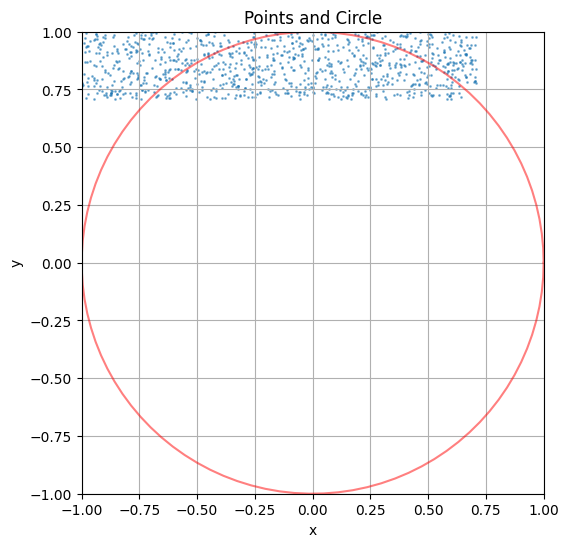

In [5]:
# Plot square, circle and points
plt.figure(figsize=(10, 6))
# take only first 1000 points for better visualization
x_plot = x[:1000]
y_plot = y[:1000]
plt.scatter(x_plot, y_plot, s=1, alpha=0.5)
theta = np.linspace(0, 2 * np.pi, 100)
x_circle = np.cos(theta)
y_circle = np.sin(theta)
plt.plot(x_circle, y_circle, color='red', alpha=0.5)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Points and Circle')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

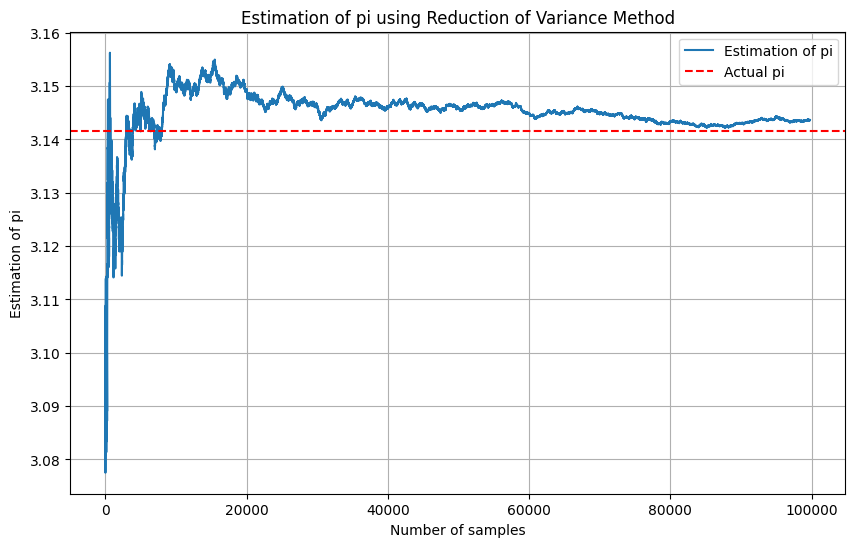

In [6]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(estimation[250:], label='Estimation of pi')
plt.axhline(y=np.pi, color='r', linestyle='--', label='Actual pi')
plt.title('Estimation of pi using Reduction of Variance Method')
plt.xlabel('Number of samples')
plt.ylabel('Estimation of pi')
plt.legend()
plt.grid()
plt.show()

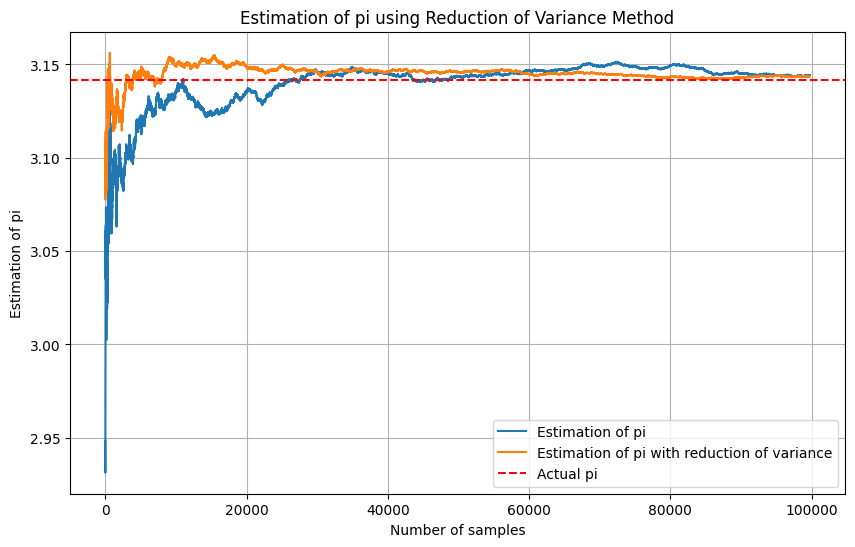

In [7]:
#compare with classic method
plt.figure(figsize=(10, 6))
plt.plot(estimate_pi[250:], label='Estimation of pi')
plt.plot(estimation[250:], label='Estimation of pi with reduction of variance')
plt.axhline(y=np.pi, color='r', linestyle='--', label='Actual pi')
plt.title('Estimation of pi using Reduction of Variance Method')
plt.xlabel('Number of samples')
plt.ylabel('Estimation of pi')
plt.legend()
plt.grid()
plt.show()

### C Recursive stratified sampling

In [8]:
# Globalne przechowywanie danych
sampled_points = []
estimations = []


def f(x, y):
    return (x ** 2 + y ** 2 <= 1).astype(float)


def estimate_sigma(f, x_min, x_max, y_min, y_max, m):
    x = np.random.uniform(x_min, x_max, m)
    y = np.random.uniform(y_min, y_max, m)
    sampled_points.extend(list(zip(x, y)))  # zapisz punkty
    values = f(x, y)
    return np.std(values) + 1e-3


def recursive_stratified_sampling(f, x_min, x_max, y_min, y_max, n, min_budget):
    if n <= min_budget:
        x = np.random.uniform(x_min, x_max, n)
        y = np.random.uniform(y_min, y_max, n)
        sampled_points.extend(list(zip(x, y)))
        values = f(x, y)
        area = (x_max - x_min) * (y_max - y_min)
        estimate = area * np.mean(values)
        estimations.append((len(sampled_points), estimate))  # zapisz estymację
        return estimate

    m = max(n // 20, 1)
    n_remaining = n - 4 * m

    xm = (x_min + x_max) / 2
    ym = (y_min + y_max) / 2

    rectangles = [
        (x_min, xm, y_min, ym),
        (xm, x_max, y_min, ym),
        (x_min, xm, ym, y_max),
        (xm, x_max, ym, y_max)
    ]

    sigmas = [estimate_sigma(f, *rect, m) for rect in rectangles]
    total_sigma = sum(sigmas)

    estimates = []
    for rect, sigma in zip(rectangles, sigmas):
        sub_n = max(int(n_remaining * sigma / total_sigma), min_budget)
        est = recursive_stratified_sampling(f, *rect, sub_n, min_budget)
        estimates.append(est)

    total_estimate = sum(estimates)
    estimations.append((len(sampled_points), total_estimate))  # zapisz postęp
    return total_estimate


# Parametry
n = 10_000
min_budget = 50

# Reset
sampled_points = []
estimations = []

# Uruchomienie
pi_est = recursive_stratified_sampling(f, -1, 1, -1, 1, n, min_budget)
print(f"Końcowa estymacja całki (π): {pi_est}")

# Opcjonalne: konwersja do numpy
sampled_points = np.array(sampled_points)

Końcowa estymacja całki (π): 3.1450213623046874


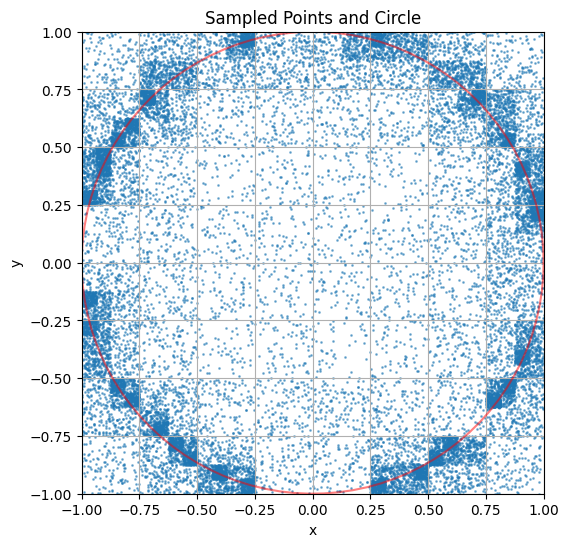

In [9]:
# Plotting the sampled points
plt.figure(figsize=(10, 6))
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], s=1, alpha=0.5)
theta = np.linspace(0, 2 * np.pi, 100)
x_circle = np.cos(theta)
y_circle = np.sin(theta)
plt.plot(x_circle, y_circle, color='red', alpha=0.5)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Sampled Points and Circle')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

Running recursive stratified sampling...
Estimate: 3.134419
Exact Value (π): 3.141593
Absolute Error: 0.007174
Relative Error: 0.002283
Number of sampled points: 10000


/var/folders/7q/jtsqqb2j4bj4j9t6p9c76vw00000gn/T/ipykernel_74457/95017059.py:202: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap),


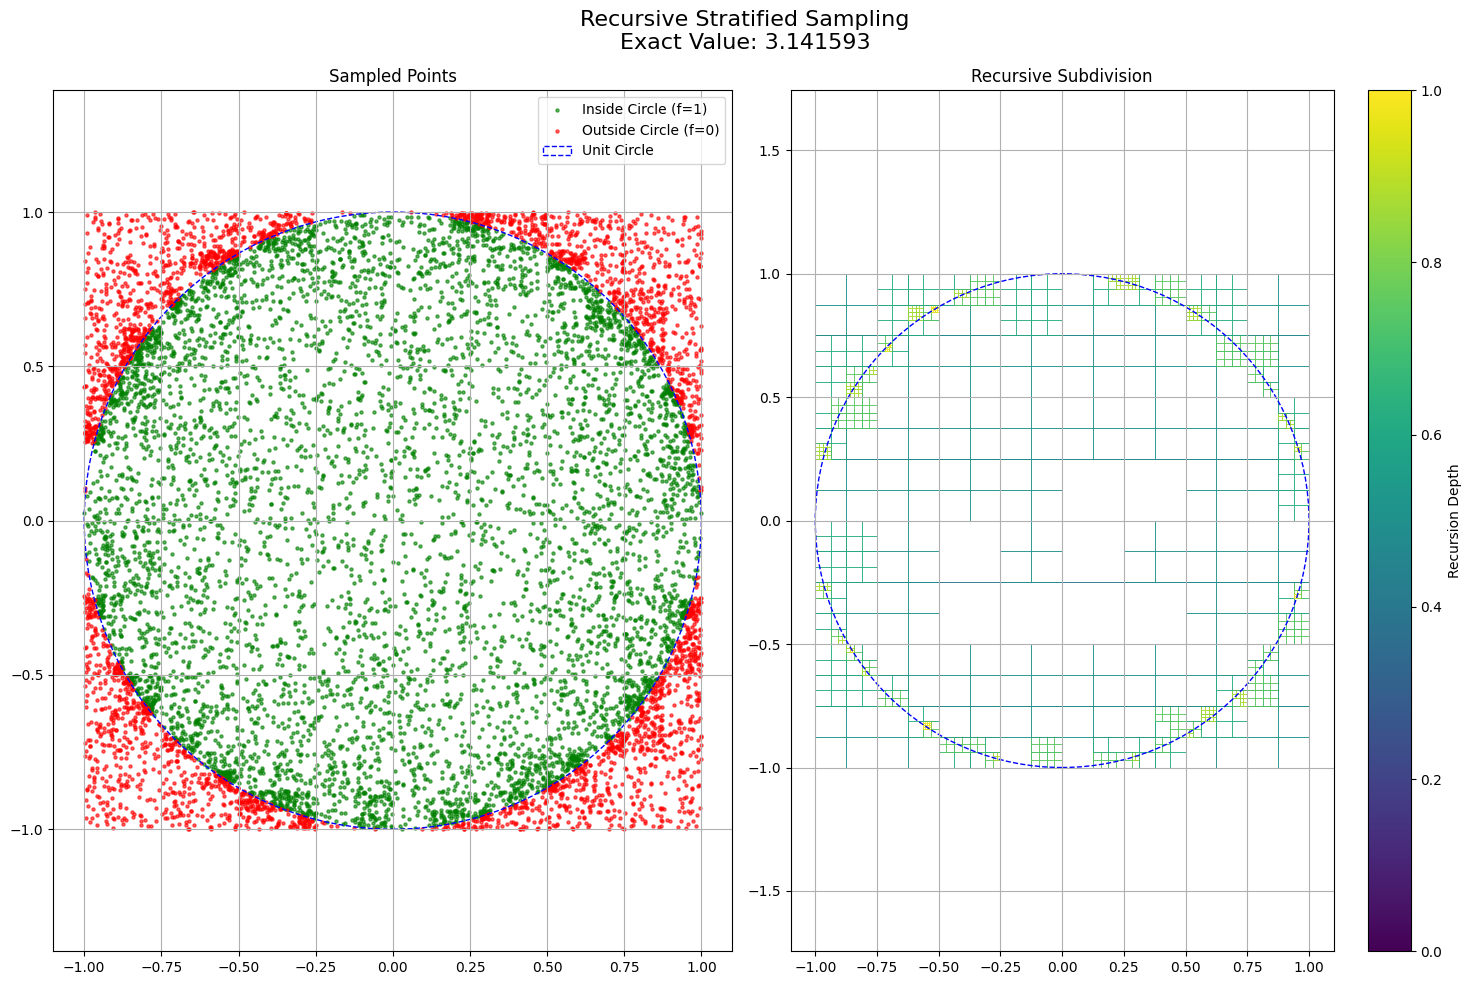


Analyzing convergence with different budgets...
Budget: 100, Estimate: 3.065972, Error: 0.075620, Time: 0.0006 sec
Budget: 400, Estimate: 3.054365, Error: 0.087228, Time: 0.0027 sec
Budget: 700, Estimate: 3.015712, Error: 0.125881, Time: 0.0032 sec
Budget: 1000, Estimate: 3.124979, Error: 0.016614, Time: 0.0040 sec
Budget: 1300, Estimate: 3.172145, Error: 0.030552, Time: 0.0046 sec
Budget: 1600, Estimate: 3.107203, Error: 0.034389, Time: 0.0051 sec
Budget: 1900, Estimate: 3.121226, Error: 0.020367, Time: 0.0068 sec
Budget: 2200, Estimate: 3.161258, Error: 0.019666, Time: 0.0076 sec
Budget: 2500, Estimate: 3.127702, Error: 0.013891, Time: 0.0076 sec
Budget: 2800, Estimate: 3.151276, Error: 0.009683, Time: 0.0100 sec
Budget: 3100, Estimate: 3.128966, Error: 0.012626, Time: 0.0121 sec
Budget: 3400, Estimate: 3.128581, Error: 0.013011, Time: 0.0129 sec
Budget: 3700, Estimate: 3.113689, Error: 0.027904, Time: 0.0120 sec
Budget: 4000, Estimate: 3.152668, Error: 0.011075, Time: 0.0126 sec
Bu

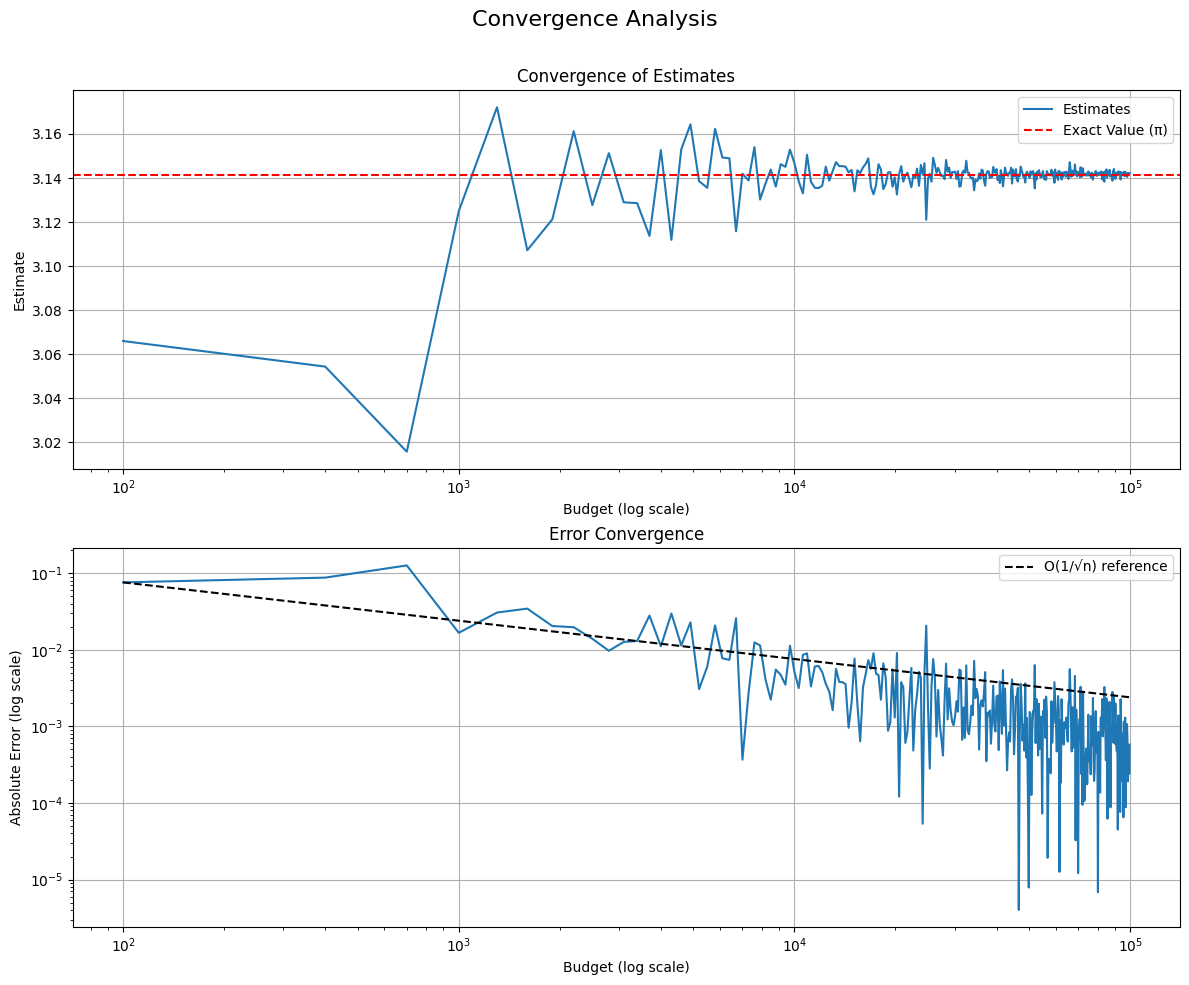

In [10]:
def f(x, y):
    """The function to integrate: indicator function for points inside a unit circle"""
    return 1 if np.sqrt(x ** 2 + y ** 2) <= 1 else 0


def recursive_stratified_sampling(a, b, c, d, budget, min_budget=10, bias=1e-3, depth=0, all_points=None,
                                  all_rectangles=None):
    """
    Recursively estimate the integral of f(x,y) over [a,b]×[c,d] using stratified sampling
    
    Parameters:
    - a, b, c, d: bounds of the rectangle
    - budget: number of function evaluations allowed
    - min_budget: minimum budget before stopping recursion
    - bias: small bias added to variance estimates for numerical stability
    - depth: current recursion depth
    - all_points: list to store all sampled points for visualization
    - all_rectangles: list to store all rectangles for visualization
    
    Returns:
    - estimate of the integral
    - all points sampled (for visualization)
    - all rectangles processed (for visualization)
    """
    if all_points is None:
        all_points = []
    if all_rectangles is None:
        all_rectangles = []

    # Record this rectangle for visualization
    all_rectangles.append((a, b, c, d, depth))

    # If budget is too small, stop recursion
    if budget < min_budget:
        # Sample points uniformly from the rectangle
        x_samples = np.random.uniform(a, b, budget)
        y_samples = np.random.uniform(c, d, budget)

        # Evaluate function at sampled points
        f_values = [f(x, y) for x, y in zip(x_samples, y_samples)]

        # Store sampled points for visualization
        for x, y, f_val in zip(x_samples, y_samples, f_values):
            all_points.append((x, y, f_val, depth))

        # Calculate area of rectangle and estimate integral
        area = (b - a) * (d - c)
        estimate = area * np.mean(f_values)

        return estimate, all_points, all_rectangles

    # Divide rectangle into 4 equal parts
    mid_x = (a + b) / 2
    mid_y = (c + d) / 2

    # Define the 4 sub-rectangles
    rectangles = [
        (a, mid_x, c, mid_y),  # Bottom-left
        (mid_x, b, c, mid_y),  # Bottom-right
        (a, mid_x, mid_y, d),  # Top-left
        (mid_x, b, mid_y, d)  # Top-right
    ]

    # Use 5% of budget for initial sampling to estimate variance in each rectangle
    pilot_budget = max(1, int(0.05 * budget))
    remaining_budget = budget - 4 * pilot_budget

    # Perform pilot sampling in each rectangle
    pilot_estimates = []
    variances = []

    for rect in rectangles:
        a_r, b_r, c_r, d_r = rect

        # Sample points uniformly from this sub-rectangle
        x_samples = np.random.uniform(a_r, b_r, pilot_budget)
        y_samples = np.random.uniform(c_r, d_r, pilot_budget)

        # Evaluate function at sampled points
        f_values = [f(x, y) for x, y in zip(x_samples, y_samples)]

        # Store sampled points for visualization
        for x, y, f_val in zip(x_samples, y_samples, f_values):
            all_points.append((x, y, f_val, depth))

        # Calculate estimate and variance for this rectangle
        rect_area = (b_r - a_r) * (d_r - c_r)
        estimate = rect_area * np.mean(f_values)
        variance = np.var(f_values) + bias  # Add small bias to avoid zero variance

        pilot_estimates.append(estimate)
        variances.append(variance)

    # Allocate remaining budget proportionally to standard deviations
    total_std = sum(np.sqrt(v) for v in variances)

    # Guard against division by zero
    if total_std == 0:
        budgets = [remaining_budget // 4] * 4
        # Distribute any remainder
        for i in range(remaining_budget % 4):
            budgets[i] += 1
    else:
        # Allocate according to standard deviations
        budgets = [int(remaining_budget * np.sqrt(v) / total_std) for v in variances]
        # Ensure minimum budget of 1 for each rectangle and distribute any remainder
        remainder = remaining_budget - sum(budgets)
        for i in range(4):
            if budgets[i] == 0:
                budgets[i] = 1
                remainder -= 1

        # Distribute any remaining budget to the rectangles with highest variance
        if remainder > 0:
            sorted_indices = np.argsort(variances)[::-1]  # Sort in descending order
            for i in range(min(remainder, 4)):
                budgets[sorted_indices[i]] += 1

    # Recursively apply stratified sampling to each sub-rectangle
    final_estimates = []
    for i, (rect, budget_i) in enumerate(zip(rectangles, budgets)):
        a_r, b_r, c_r, d_r = rect
        if budget_i > 0:  # Only process if there's a budget allocated
            estimate, all_points, all_rectangles = recursive_stratified_sampling(
                a_r, b_r, c_r, d_r, budget_i, min_budget, bias, depth + 1, all_points, all_rectangles
            )
            final_estimates.append(estimate)
        else:
            # If no budget, use the pilot estimate
            final_estimates.append(pilot_estimates[i])

    # Return the sum of estimates from all sub-rectangles
    return sum(final_estimates), all_points, all_rectangles


def visualize_results(all_points, all_rectangles, exact_value):
    """
    Visualize the sampled points and rectangles from recursive stratified sampling
    
    Parameters:
    - all_points: list of (x, y, f_value, depth)
    - all_rectangles: list of (a, b, c, d, depth)
    - exact_value: exact value of the integral for comparison
    """
    plt.figure(figsize=(15, 10))

    # Create subplot for the sampled points
    plt.subplot(1, 2, 1)

    # Extract points and their function values
    xs = [p[0] for p in all_points]
    ys = [p[1] for p in all_points]
    f_values = [p[2] for p in all_points]
    depths = [p[3] for p in all_points]

    # Calculate max depth for color scaling
    max_depth = max(depths) if depths else 0

    # Plot interior points (f = 1) in green, exterior points (f = 0) in red
    interior_points = [(x, y) for x, y, f_val, _ in all_points if f_val == 1]
    exterior_points = [(x, y) for x, y, f_val, _ in all_points if f_val == 0]

    if interior_points:
        int_xs, int_ys = zip(*interior_points)
        plt.scatter(int_xs, int_ys, c='green', alpha=0.6, s=5, label='Inside Circle (f=1)')

    if exterior_points:
        ext_xs, ext_ys = zip(*exterior_points)
        plt.scatter(ext_xs, ext_ys, c='red', alpha=0.6, s=5, label='Outside Circle (f=0)')

    # Plot the unit circle
    circle = plt.Circle((0, 0), 1, fill=False, color='blue', linestyle='--', label='Unit Circle')
    plt.gca().add_patch(circle)

    plt.axis('equal')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.grid(True)
    plt.title('Sampled Points')
    plt.legend()

    # Create subplot for the rectangles
    plt.subplot(1, 2, 2)

    # Plot rectangles with color based on depth
    cmap = plt.cm.viridis
    for a, b, c, d, depth in all_rectangles:
        color = cmap(depth / max(max_depth, 1))
        rect = Rectangle((a, c), b - a, d - c, fill=False, edgecolor=color, linewidth=0.5)
        plt.gca().add_patch(rect)

    # Plot the unit circle
    circle = plt.Circle((0, 0), 1, fill=False, color='blue', linestyle='--')
    plt.gca().add_patch(circle)

    plt.axis('equal')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.grid(True)
    plt.title('Recursive Subdivision')

    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap),
                 label='Recursion Depth')

    plt.tight_layout()
    plt.suptitle(f'Recursive Stratified Sampling\nExact Value: {exact_value:.6f}',
                 fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()


def run_multiple_budgets(budgets, min_budget=10):
    """
    Run recursive stratified sampling with different total budgets
    
    Parameters:
    - budgets: list of budget values to try
    - min_budget: minimum budget for recursion stopping criterion
    
    Returns:
    - list of estimates for each budget
    - list of errors for each budget
    - execution times for each budget
    """
    exact_value = np.pi  # The exact value of the integral (area of unit circle)

    estimates = []
    errors = []
    times = []

    for budget in budgets:
        start_time = time.time()
        estimate, all_points, all_rectangles = recursive_stratified_sampling(
            -1, 1, -1, 1, budget, min_budget
        )
        end_time = time.time()

        error = abs(estimate - exact_value)

        estimates.append(estimate)
        errors.append(error)
        times.append(end_time - start_time)

        print(f"Budget: {budget}, Estimate: {estimate:.6f}, Error: {error:.6f}, Time: {end_time - start_time:.4f} sec")

    return estimates, errors, times


def analyze_convergence(budgets, estimates, errors):
    """Plot convergence analysis of the estimates"""
    exact_value = np.pi

    plt.figure(figsize=(12, 10))

    # Plot estimates vs budget
    plt.subplot(2, 1, 1)
    plt.plot(budgets, estimates,  label='Estimates')
    plt.axhline(y=exact_value, color='r', linestyle='--', label='Exact Value (π)')
    plt.xscale('log')
    plt.xlabel('Budget (log scale)')
    plt.ylabel('Estimate')
    plt.title('Convergence of Estimates')
    plt.grid(True)
    plt.legend()

    # Plot errors vs budget
    plt.subplot(2, 1, 2)
    plt.plot(budgets, errors)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Budget (log scale)')
    plt.ylabel('Absolute Error (log scale)')
    plt.title('Error Convergence')
    plt.grid(True)

    # Add theoretical O(1/sqrt(n)) convergence line for comparison
    ref_x = np.array(budgets)
    ref_y = errors[0] * np.sqrt(budgets[0]) / np.sqrt(ref_x)
    plt.plot(ref_x, ref_y, 'k--', label='O(1/√n) reference')
    plt.legend()

    plt.tight_layout()
    plt.suptitle('Convergence Analysis', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()


# Set random seed for reproducibility
np.random.seed(42)

# Define the budget and minimum budget for stopping recursion
total_budget = 10000
min_budget = 10

# Run the recursive stratified sampling
print("Running recursive stratified sampling...")
estimate, all_points, all_rectangles = recursive_stratified_sampling(
    -1, 1, -1, 1, total_budget, min_budget
)

# Calculate the exact value (area of unit circle)
exact_value = np.pi
error = abs(estimate - exact_value)

print(f"Estimate: {estimate:.6f}")
print(f"Exact Value (π): {exact_value:.6f}")
print(f"Absolute Error: {error:.6f}")
print(f"Relative Error: {error / exact_value:.6f}")
print(f"Number of sampled points: {len(all_points)}")

# Visualize the results
visualize_results(all_points, all_rectangles, exact_value)

# Run with multiple budgets for convergence analysis
print("\nAnalyzing convergence with different budgets...")
#budgets = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000, 80000, 90000, 100000]
#budgets = [i * 100 * 10 ** j  for j in range(1, 3) for i in range(1,11)]
budgets = [ i * 100 for i in range(1, 1000, 3)]
estimates_strat, errors, times = run_multiple_budgets(budgets, min_budget)

# Plot convergence analysis
analyze_convergence(budgets, estimates_strat, errors)

### Summary

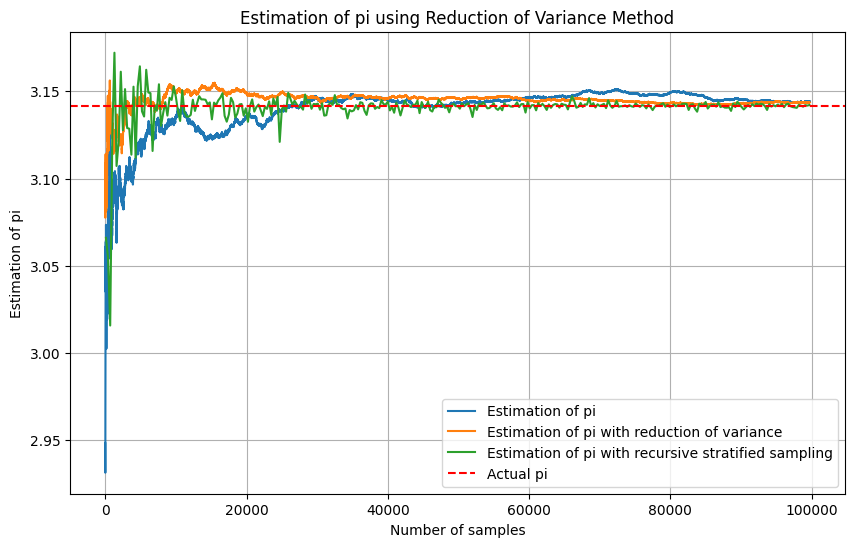

In [11]:
#compare with classic method
plt.figure(figsize=(10, 6))
plt.plot(estimate_pi[250:], label='Estimation of pi')
plt.plot(estimation[250:], label='Estimation of pi with reduction of variance')
plt.plot(budgets,estimates_strat, label='Estimation of pi with recursive stratified sampling')
plt.axhline(y=np.pi, color='r', linestyle='--', label='Actual pi')
plt.title('Estimation of pi using Reduction of Variance Method')
plt.xlabel('Number of samples')
plt.ylabel('Estimation of pi')
plt.legend()
plt.grid()
plt.show()

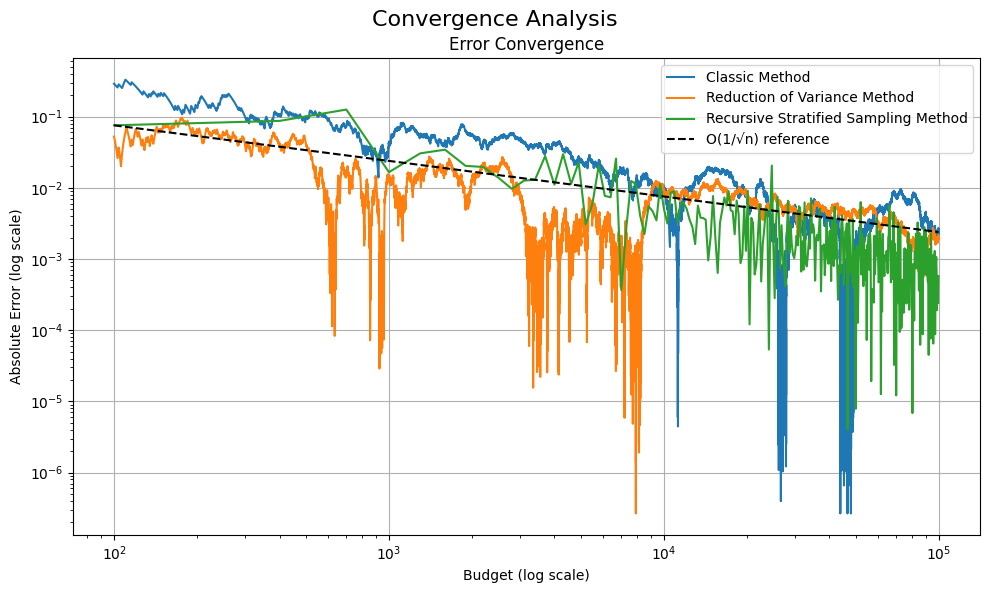

In [12]:
errors_a = abs(np.array(estimate_pi)-np.pi)
errors_b = abs(np.array(estimation)-np.pi)
errors_c = errors # budget is x
#from 100 to 100000
numbers = [i for i in range(100, 100000, 1)]
plt.figure(figsize=(10, 6))
plt.plot(numbers, errors_a[100:], label='Classic Method')
plt.plot(numbers, errors_b[100:], label='Reduction of Variance Method')
plt.plot(budgets, errors_c, label='Recursive Stratified Sampling Method')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Budget (log scale)')
plt.ylabel('Absolute Error (log scale)')
plt.title('Error Convergence')
plt.grid(True)

# Add theoretical O(1/sqrt(n)) convergence line for comparison
ref_x = np.array(budgets)
ref_y = errors[0] * np.sqrt(budgets[0]) / np.sqrt(ref_x)
plt.plot(ref_x, ref_y, 'k--', label='O(1/√n) reference')
plt.legend()

plt.tight_layout()
plt.suptitle('Convergence Analysis', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

## Exercise 2 - Integral estimation
$$
I = \int_{10}^{\infty} \frac{1}{1+x^2} |\sin(x)| dx.
$$

In [13]:
n = 1000_000

In [14]:
# direct integration using scipy
integral_exact_using_scipy = integrate.quad(lambda x: (1/(1+x**2)) * abs(np.sin(x)), 10, np.inf)[0]
print(f"Direct integration result: {integral_exact_using_scipy}")

Direct integration result: 0.06549777508158958


/var/folders/7q/jtsqqb2j4bj4j9t6p9c76vw00000gn/T/ipykernel_74457/2687059942.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_exact_using_scipy = integrate.quad(lambda x: (1/(1+x**2)) * abs(np.sin(x)), 10, np.inf)[0]


### A Cauchy Distribution
$$
\mathbb{E}[|sin(X)| \mathbf{1}_{[10, \infty]}(X)] = \int_{10}^{\infty} \frac{1}{\pi} \frac{1}{1+x^2} |\sin(x)| dx
$$
where $X \sim Cauchy(0, 1)$

ChatGPT said that:

$$
\int_{10}^{\infty} \frac{|\sin(x)|}{1 + x^2} \, dx \approx 0.0655
$$

In [15]:
def cauchy_estimation(n_samples=1000000):
    samples = stats.cauchy.rvs(size=n_samples)
    #if sample is < 10 then change it to 0
    samples[samples < 10] = 0
    # calculate absolute value of sin
    samples = np.abs(np.sin(samples))
    # calculate cumulative sum
    samples_cumsum = np.cumsum(samples)
    # calculate average
    for i in range(len(samples_cumsum)):
        samples_cumsum[i] = samples_cumsum[i] / (i + 1)
    # calculate integral
    integral = samples_cumsum * np.pi
    return integral, len(samples)

In [16]:
# Run the Cauchy estimation
integral, n_samples = cauchy_estimation(n)
print(f"Estimated integral: {integral[-1]}")
print(f"Number of samples: {n_samples}")

Estimated integral: 0.06612326004140348
Number of samples: 1000000


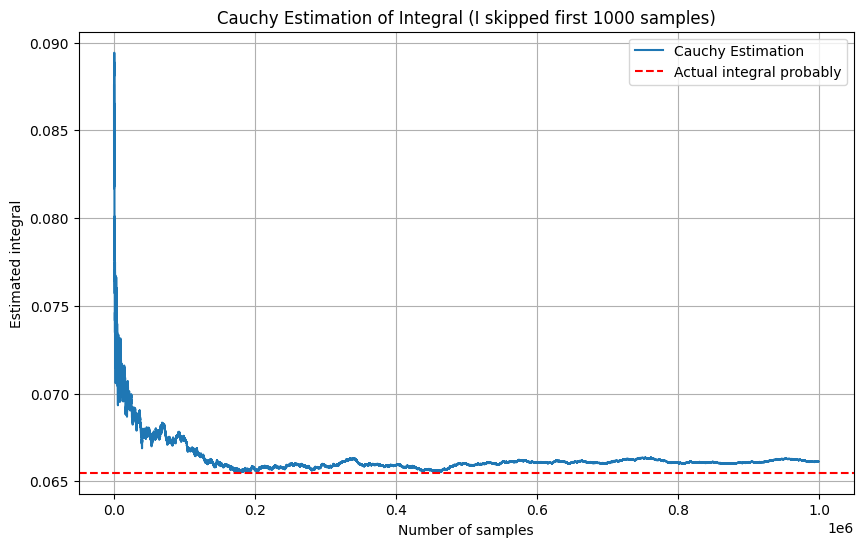

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(integral[1000:], label='Cauchy Estimation')
plt.axhline(y=0.0655, color='r', linestyle='--', label='Actual integral probably')
plt.title('Cauchy Estimation of Integral (I skipped first 1000 samples)')
plt.xlabel('Number of samples')
plt.ylabel('Estimated integral')
plt.legend()
plt.grid()
plt.show()

### B Importance Sampling
$$
I = \int_{10}^{\infty} \frac{1}{1+x^2} |\sin(x)| dx.
$$

$$
I = \pi \cdot \mathbb{E} \left[ \frac{1 + (X - 10)^2}{1 + X^2}  \cdot |\sin(X)| \cdot 1_{X \in [10, \infty]} \right]
$$

where $X \sim Cauchy(10, 1)$ 

In [18]:
def importance_sampling_cauchy(n_sample=1000000):
    samples = stats.cauchy.rvs(loc=10, scale=1, size=n_samples)
    samples[samples < 10] = 0
    samples = np.abs(np.sin(samples)) * ((1 + (samples - 10) ** 2) / (1 + samples ** 2))
    samples_cumsum = np.cumsum(samples)
    for i in range(len(samples_cumsum)):
        samples_cumsum[i] = samples_cumsum[i] / (i + 1)
    integral = samples_cumsum * np.pi
    return integral, len(samples)

In [19]:
# Run the importance sampling estimation
integral_b, n_samples = importance_sampling_cauchy(n)

print(f"Estimated integral: {integral_b[-1]}")
print(f"Number of samples: {n_samples}")

Estimated integral: 0.06575424900586467
Number of samples: 1000000


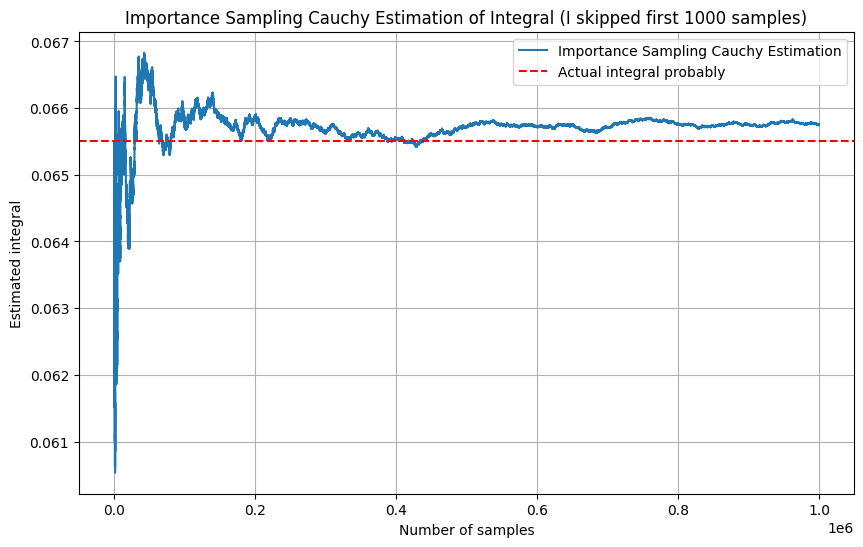

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(integral_b[1000:], label='Importance Sampling Cauchy Estimation')
plt.axhline(y=0.0655, color='r', linestyle='--', label='Actual integral probably')
plt.title('Importance Sampling Cauchy Estimation of Integral (I skipped first 1000 samples)')
plt.xlabel('Number of samples')
plt.ylabel('Estimated integral')
plt.legend()
plt.grid()
plt.show()

### C Control Variates
Useful: https://en.wikipedia.org/wiki/Control_variates

In [21]:
def estimation_control_var(n_samples=1000000):
    upper_bound = 10000
    samples = np.random.uniform(10, upper_bound, n_samples)
    f_values = np.abs(np.sin(samples)) / (1 + samples**2)
    g_values = 1 / (1 + samples**2)
    exact_g_integral = np.pi/2 - np.arctan(10)
    estimated_g_integral = np.mean(g_values) * (upper_bound - 10)
    cov_fg = np.mean(f_values * g_values) - np.mean(f_values) * np.mean(g_values)
    var_g = np.var(g_values)
    c = cov_fg / var_g if var_g > 0 else 0
    estimator_cv = np.mean(f_values) * (upper_bound - 10) - c * (estimated_g_integral - exact_g_integral)

    return estimator_cv

In [22]:
print("Estimated integral using control variates:", estimation_control_var())

Estimated integral using control variates: 0.06545891628537388


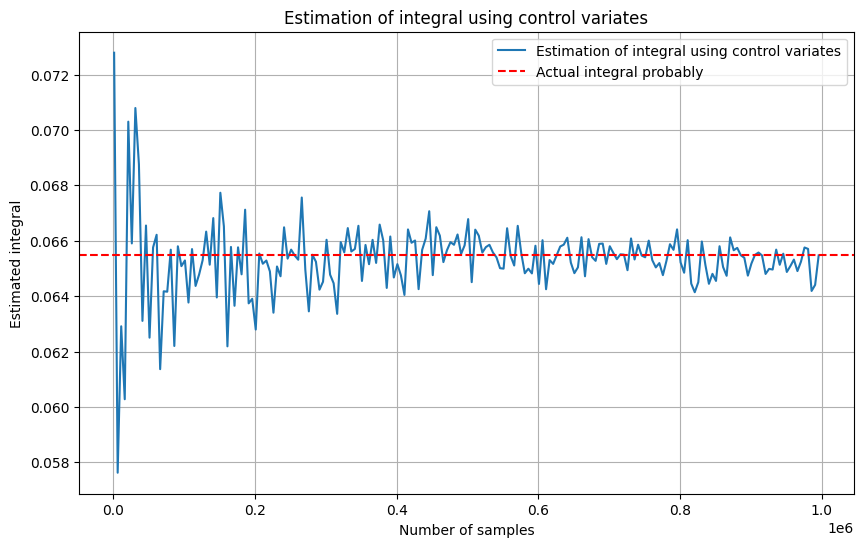

In [23]:
budgets = [ i * 1000 for i in range(1, int(n//1000) , 5)]
estimates_c = []

for budget in budgets:
    estimates_c.append(estimation_control_var(budget))
    
plt.figure(figsize=(10, 6))
plt.plot(budgets, estimates_c, label='Estimation of integral using control variates')
plt.axhline(y=0.0655, color='r', linestyle='--', label='Actual integral probably')
plt.title('Estimation of integral using control variates')
plt.xlabel('Number of samples')
plt.ylabel('Estimated integral')
plt.legend()
plt.grid()
plt.show()

### D substitution

$$
I = \int_{10}^{\infty} \frac{1}{1+x^2} |\sin(x)| dx.
$$
$$
u = \frac{1}{x}
$$$$
dx = -\frac{1}{u^2}du
$$$$
\int_{10}^{\infty} \frac{1}{1+x^2} |\sin(x)| dx = \int_{0.1}^{0} \frac{1}{1+\frac{1}{u^2}} \left|\sin\left(\frac{1}{u}\right)\right| \left(-\frac{1}{u^2}\right) du

= \int_{0}^{0.1} \frac{u^2}{u^2+1} \left|\sin\left(\frac{1}{u}\right)\right| \frac{1}{u^2} du

= \int_{0}^{0.1} \frac{1}{u^2+1} \left|\sin\left(\frac{1}{u}\right)\right| du
$$
We are going to use Uniform distr $[0,0.1]$

$$
I = 0.1  \int_{0}^{0.1} \frac{1}{u^2+1} \left|\sin\left(\frac{1}{u}\right) \right| \cdot 10 du
$$

$$
I = 0.1  \mathbb{E} \left[ \frac{1}{X^2+1} \left|\sin\left(\frac{1}{X}\right) \right|  \right]
$$
where $X \sim U(0, 0.1)$


In [24]:
def substitution_integral(n_samples=1000000):
    samples = np.random.uniform(0, 0.1, n_samples)
    samples = np.abs(np.sin(1/samples)) / (1 + samples**2)
    samples_cumsum = np.cumsum(samples)
    for i in range(len(samples_cumsum)):
        samples_cumsum[i] = samples_cumsum[i] / (i + 1)
    integral = samples_cumsum * 0.1 
    return integral

In [25]:
# Run the substitution integral estimation
integral_d = substitution_integral(n)
print(f"Estimated integral: {integral_d[-1]}")

Estimated integral: 0.06535256087361511


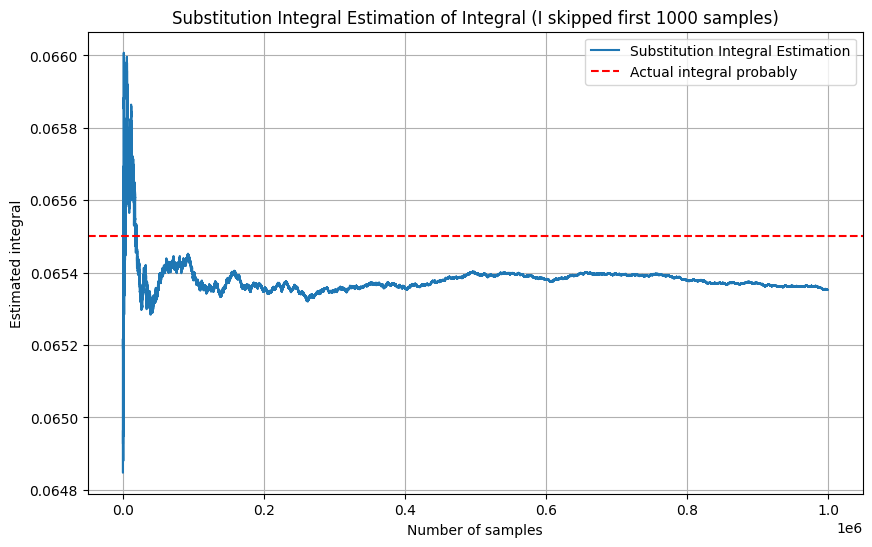

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(integral_d[1000:], label='Substitution Integral Estimation')
plt.axhline(y=0.0655, color='r', linestyle='--', label='Actual integral probably')
plt.title('Substitution Integral Estimation of Integral (I skipped first 1000 samples)')
plt.xlabel('Number of samples')
plt.ylabel('Estimated integral')
plt.legend()
plt.grid()
plt.show()

### Compare all methods

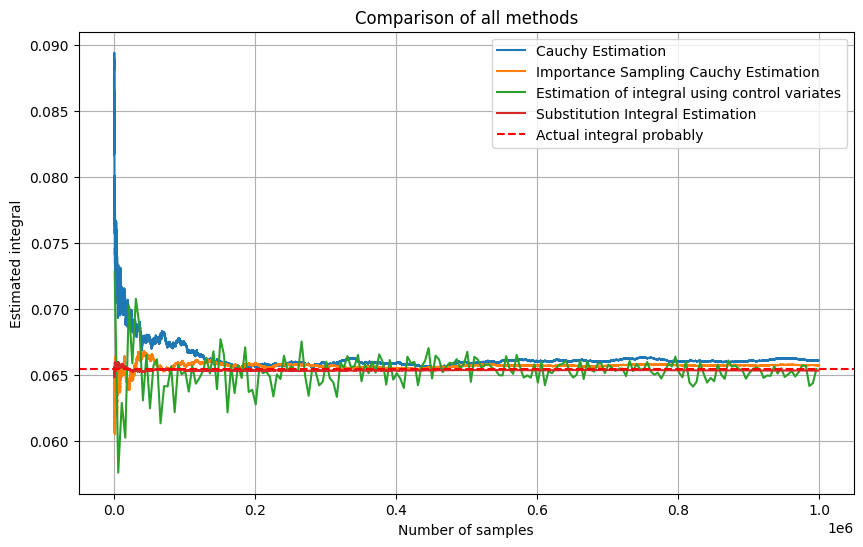

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(integral[1000:], label='Cauchy Estimation')
plt.plot(integral_b[1000:], label='Importance Sampling Cauchy Estimation')
plt.plot(budgets, estimates_c, label='Estimation of integral using control variates')
plt.plot(integral_d[1000:], label='Substitution Integral Estimation')
plt.axhline(y=0.0655, color='r', linestyle='--', label='Actual integral probably')
plt.title('Comparison of all methods')
plt.xlabel('Number of samples')
plt.ylabel('Estimated integral')
plt.legend()
plt.grid()
plt.show()

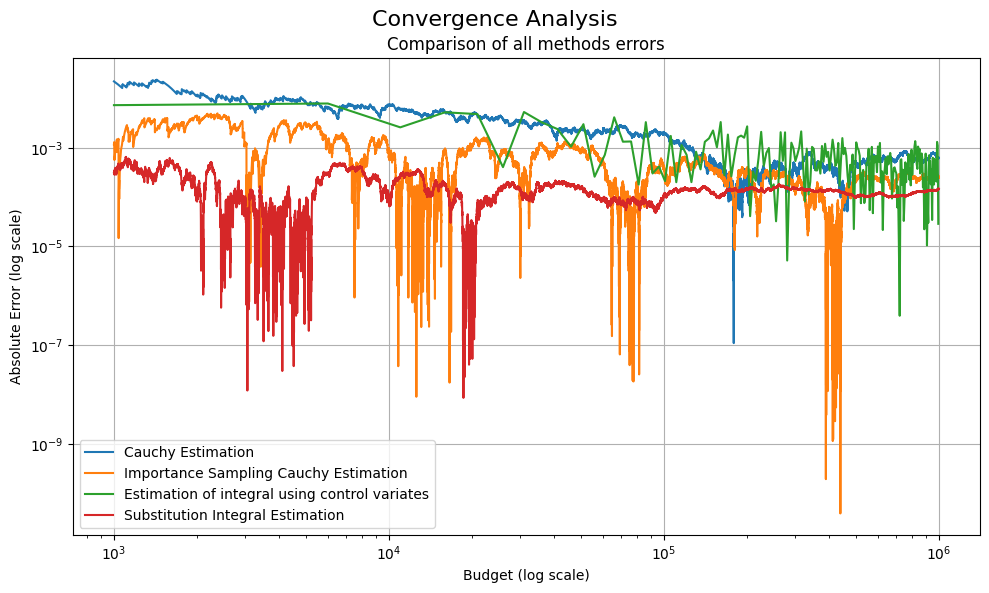

In [28]:
# Plotting errors
err_A= abs(integral - 0.0655)
err_B = abs(integral_b - 0.0655)
err_C = abs(np.array(estimates_c) - 0.0655)
err_D = abs(integral_d - 0.0655)

numbers = [ i for i in range(1000, n, 1)]

plt.figure(figsize=(10, 6))
plt.plot(numbers, err_A[1000:], label='Cauchy Estimation')
plt.plot(numbers, err_B[1000:], label='Importance Sampling Cauchy Estimation')
plt.plot(budgets, err_C, label='Estimation of integral using control variates')
plt.plot(numbers, err_D[1000:], label='Substitution Integral Estimation')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Budget (log scale)')
plt.ylabel('Absolute Error (log scale)')
plt.title('Comparison of all methods errors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.suptitle('Convergence Analysis', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()